In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>Note:</b> the raw code for this notebook is by default hidden for easier reading.
To toggle the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

# Setup

In [2]:
import torch
import Darwin as dw
import seaborn as sns

from torchvision import datasets, transforms
from bogus import atk
from ipywidgets  import interactive, fixed
from bokeh.io import output_notebook

output_notebook()
sns.set()

Loading BokehJS ...

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor()])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=True, download=True,
                            transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=False, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(
                            MNIST_train, batch_size=64, 
                            shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                            batch_size=1000, shuffle=True, 
                            pin_memory=True)

In [4]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

In [5]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [6]:
atk_func = atk()

# Run 

In [7]:
testing = dw.TournamentOptimizer(2, LAYER_SPACE, NET_SPACE, dw.randomize_network, 
                           dw.mutate_net, dw.NetFromBuildInfo, dw.train, dw.test,
                          train_loader, test_loader, atk_func.fgsm)

In [8]:
testing.step(generations=1, save=True, phone=False)

Generation 1 Population mean:875.0 max:1334

Top performers:
0: score:1334
1: score:416



# Plots

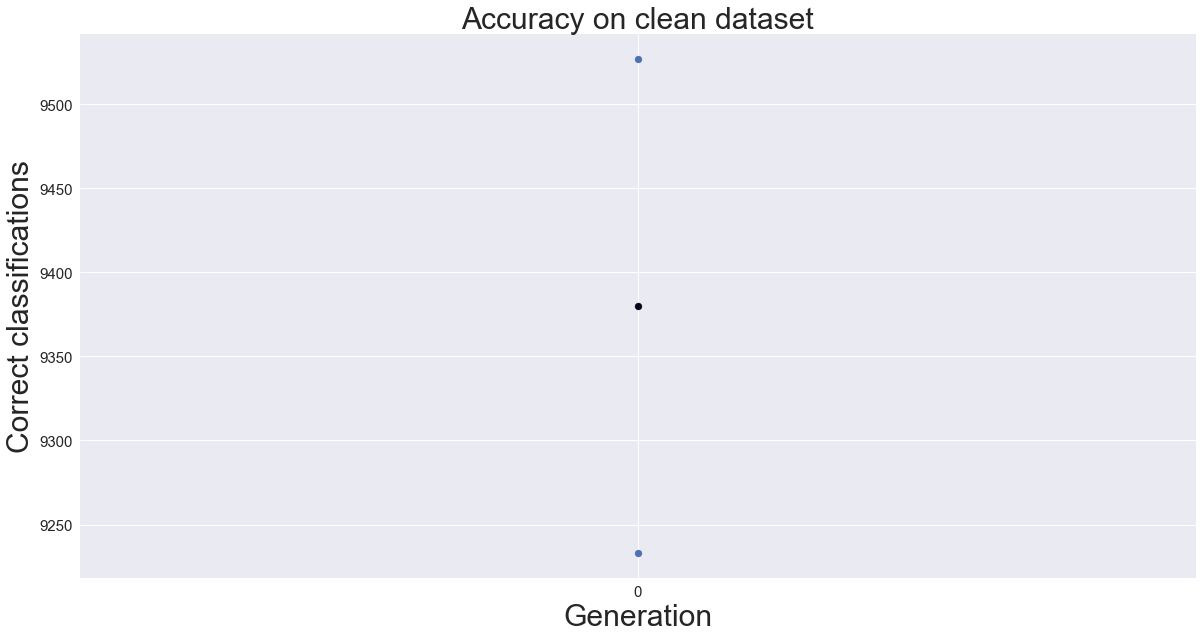

In [9]:
dw.progressplotter(testing, clean=True)

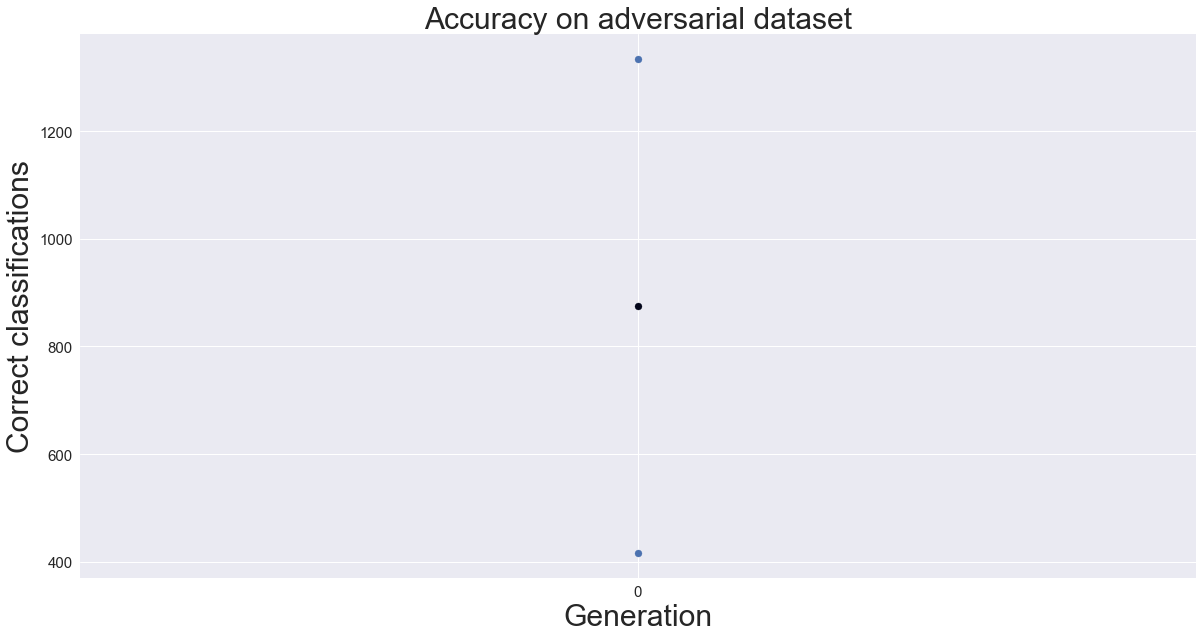

In [10]:
dw.progressplotter(testing)

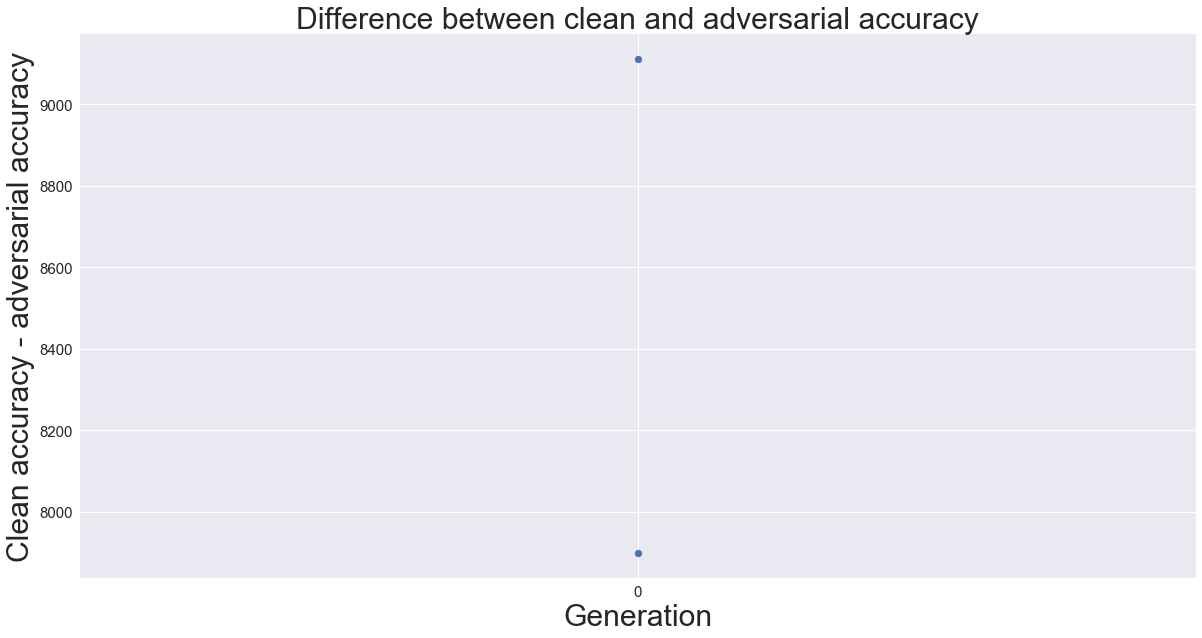

In [11]:
dw.diffplotter(testing)

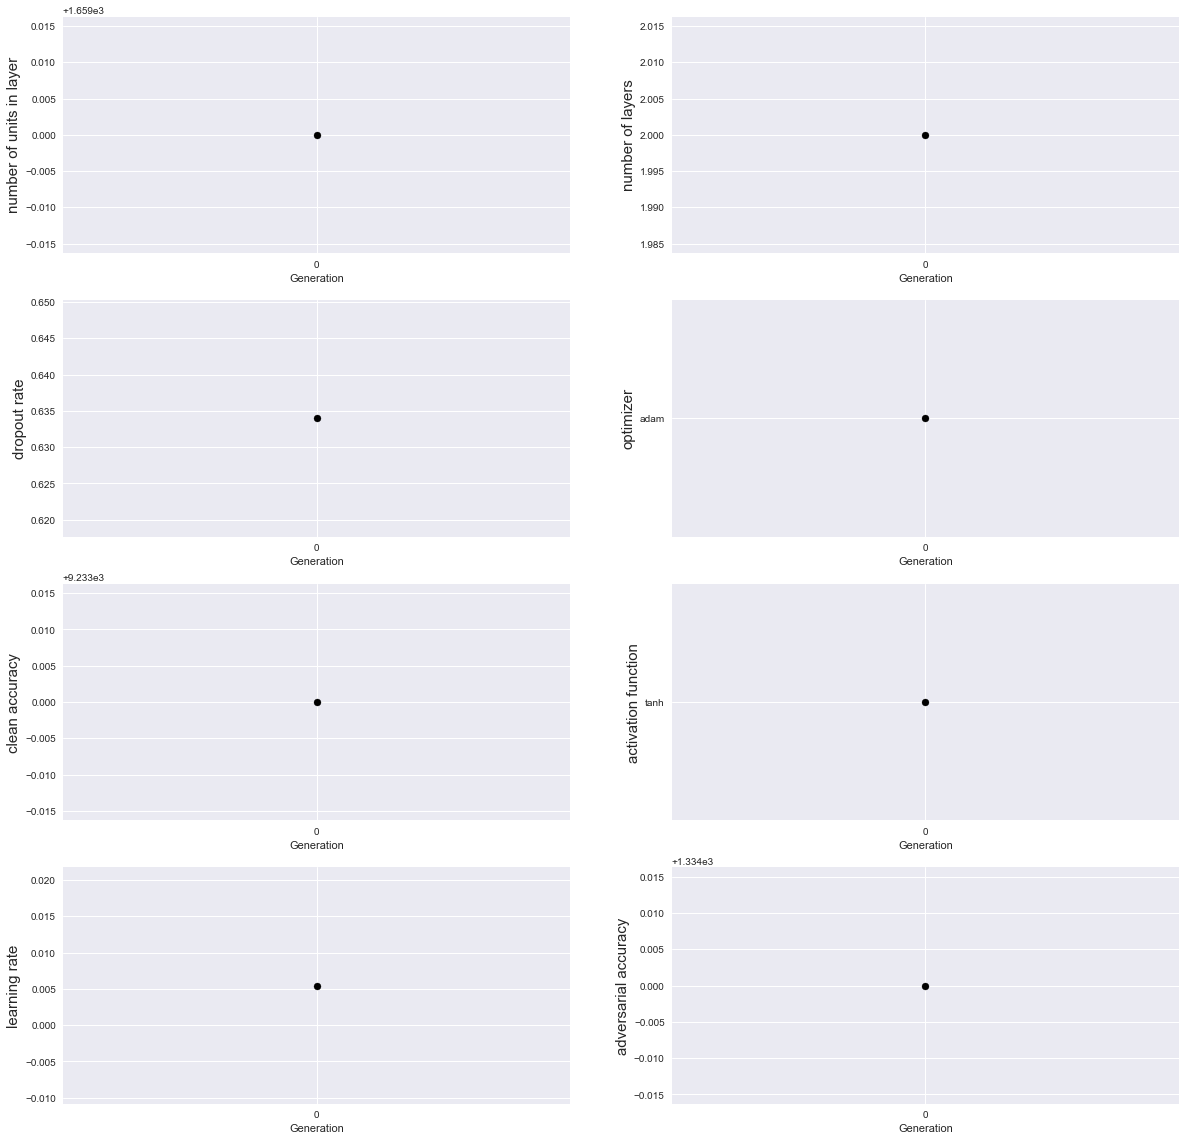

In [12]:
dw.bestplotter(testing, k=0)

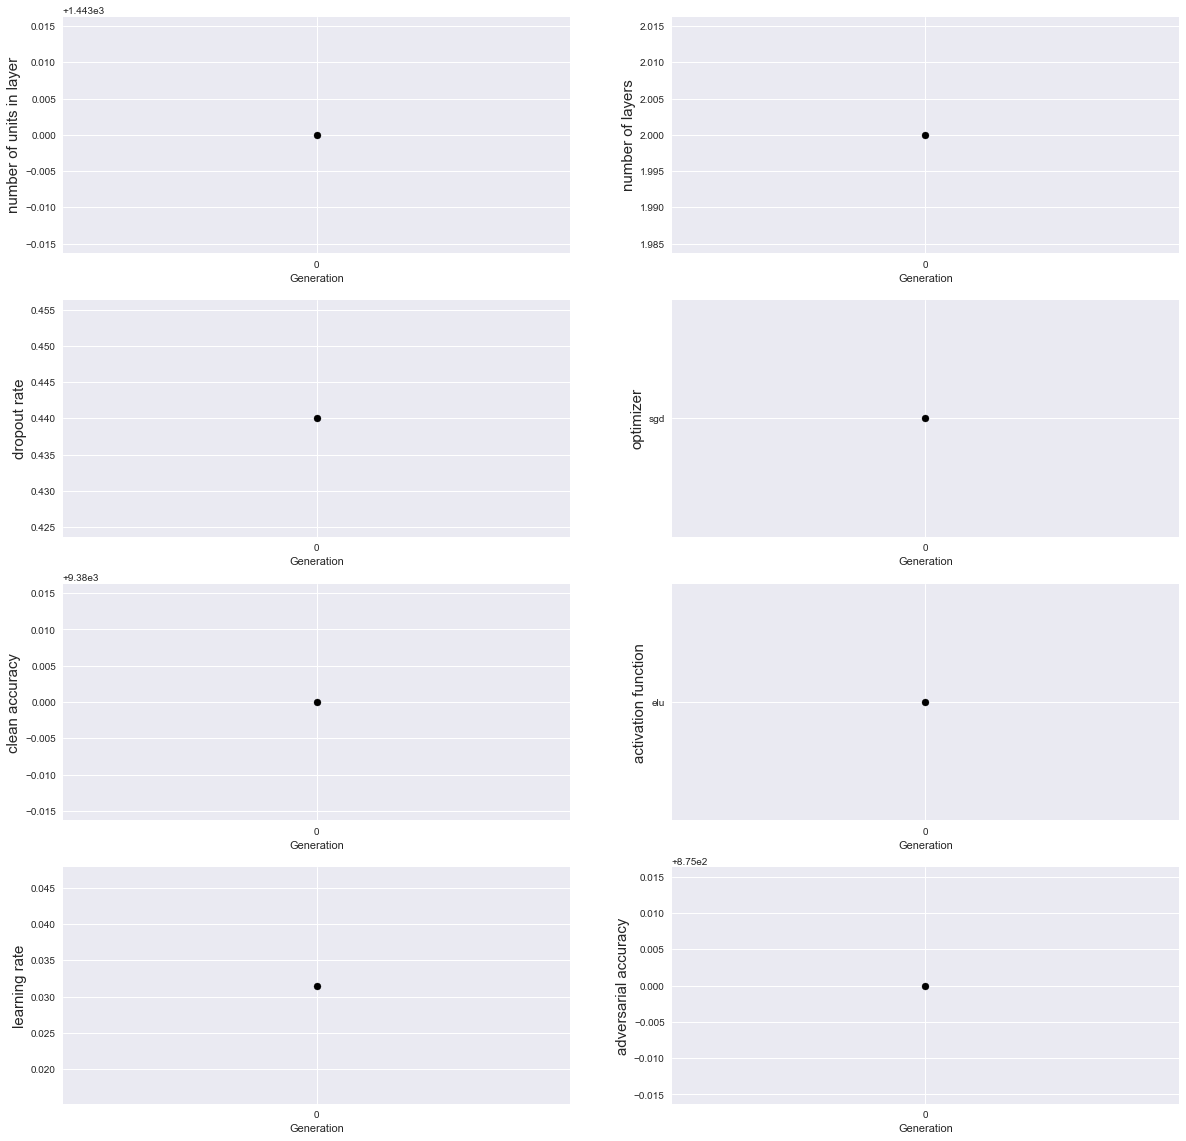

In [13]:
dw.avgplotter(testing)

In [14]:
dw.best_printer(testing)

,adversarial,clean,generation
best_adversarial,1334,9233,1
best_clean,416,9527,1


Showing best model which was found in generation 1
Clean accuracy = 9233
adversarial accuracy =1334

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1659, bias=True)
    (dropout_0): Dropout(p=0.6339616882232403)
    (tanh0): Tanh()
    (fc_1): Linear(in_features=1659, out_features=334, bias=True)
    (dropout_1): Dropout(p=0.18259353047309806)
    (relu1): ReLU()
    (logits): Linear(in_features=334, out_features=10, bias=True)
    (log_softmax): LogSoftmax()
  )
) 

 Images below are adversarial


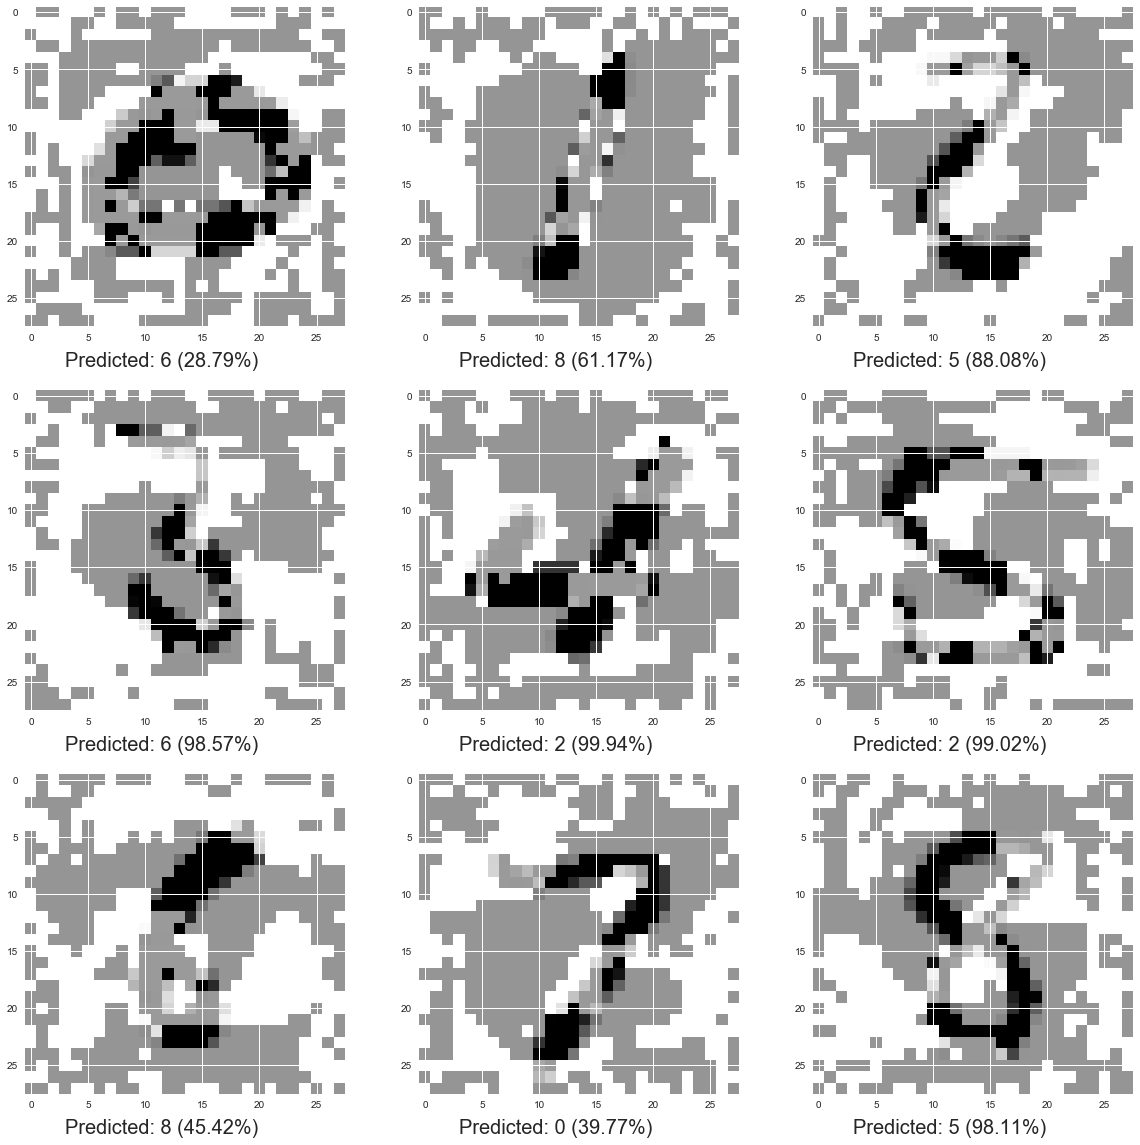

In [15]:
dw.multi_plot(testing, test_loader, adv_func=atk_func.fgsm, adversarial=True, eps=0.5)

Showing best model which was found in generation 1
Clean accuracy = 9233
adversarial accuracy =1334

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1659, bias=True)
    (dropout_0): Dropout(p=0.6339616882232403)
    (tanh0): Tanh()
    (fc_1): Linear(in_features=1659, out_features=334, bias=True)
    (dropout_1): Dropout(p=0.18259353047309806)
    (relu1): ReLU()
    (logits): Linear(in_features=334, out_features=10, bias=True)
    (log_softmax): LogSoftmax()
  )
) 

 Images below are clean


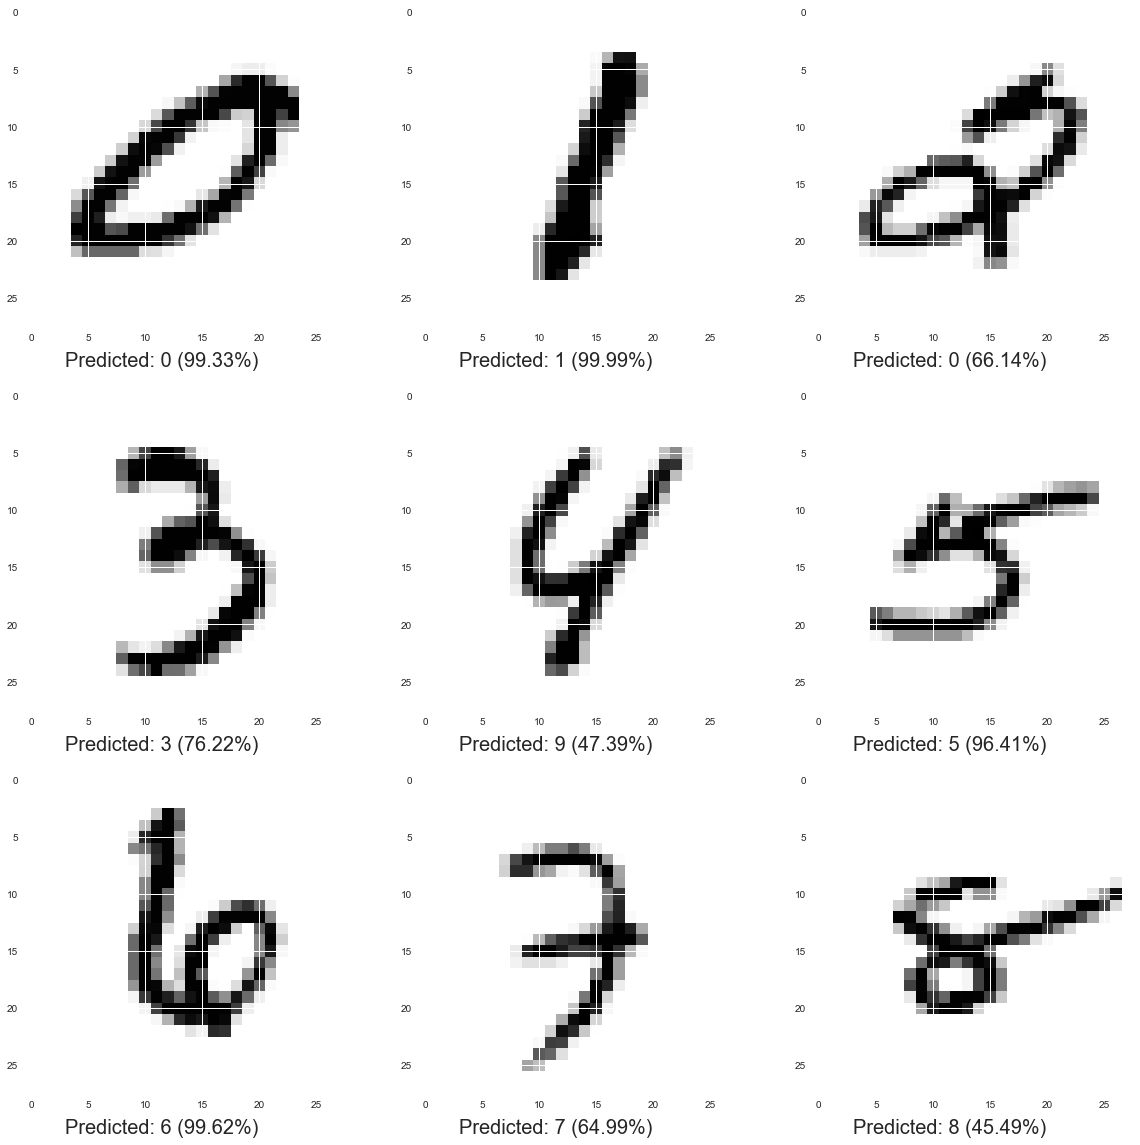

In [16]:
dw.multi_plot(testing, test_loader, adversarial=False)

In [17]:
df = dw.dataframer(testing)
#df.to_pickle(r"../data/neuroevolution4")

In [18]:
opts = df.columns.tolist()[:-1] #last column contains dicts which causes bokeh to fail
gen_opts = ['all'] + df['Generation'].unique().tolist() 
y1_opts = opts[2:] + opts[:2]
y2_opts = opts[1:] + opts[:1]
interactive_plot = interactive(dw.int_plot, df=fixed(df), x=opts, y=y1_opts, x2=opts, y2=y2_opts, gen=gen_opts)

In [19]:
interactive_plot #bokeh does not show on Github due to JS restrictions

interactive(children=(Dropdown(description='x', options=('Generation', 'Clean', 'Adversarial', 'No_layers', 'L…